# COMPSCI 671D Fall 2020
## Kaggle Competition:  Airbnb price classification

### Sayan Mandal - uid: sayanmndl21

In [1]:
#import all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
import time
from datetime import date
import seaborn as sns
from geopy import distance as geodist
from datetime import datetime

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb


%matplotlib inline

# Exploratory Data Analysis

In [2]:
#read files
dftr = pd.read_csv('train.csv')
df = pd.read_csv('test.csv')

In [3]:
dftr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9681 entries, 0 to 9680
Data columns (total 25 columns):
id                                  9681 non-null int64
neighbourhood                       9681 non-null object
room_type                           9681 non-null object
minimum_nights                      9681 non-null int64
number_of_reviews                   9681 non-null int64
last_review                         9681 non-null object
reviews_per_month                   9681 non-null float64
calculated_host_listings_count      9681 non-null int64
availability_365                    9681 non-null int64
host_since                          9681 non-null object
host_is_superhost                   9681 non-null object
bathrooms                           9681 non-null float64
bedrooms                            9681 non-null int64
beds                                9681 non-null int64
bed_type                            9681 non-null object
cleaning_fee                        9681 no

In [4]:
dftr.head(5).T

,0,1,2,3,4
id,727,6274,6025,8931,7524
neighbourhood,Palermo,Colegiales,Recoleta,Recoleta,San Nicolás
room_type,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt
minimum_nights,1,1,3,2,2
number_of_reviews,170,11,2,1,31
last_review,5/12/20,7/1/19,11/23/19,11/1/19,12/26/19
reviews_per_month,2.48,0.57,0.08,0.13,1.54
calculated_host_listings_count,4,1,19,1,5
availability_365,346,0,360,267,365
host_since,8/1/13,2/14/14,10/19/17,2/1/19,1/24/15


#### Types of columns (features):
Date: 'host_since', 'last_review'

Numerical: 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights'
            
Ordinal: 'room_type', 'bed_type', 'cancellation_policy'
    
Nominal: 'host_is_superhost', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification', 'neighbourhood'

Arbitrary: 'is_business_travel_ready'

## Initial experiments
### Onehot encode and test on basic model: KNeighboursClassifier

In [5]:
y_ = dftr['price']
X_ = dftr.drop(['id','price'], axis=1)

nominalcols = ['neighbourhood', 'room_type','last_review','host_since','host_is_superhost','bed_type','instant_bookable','is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification']
# onehot encodings
X_ = pd.get_dummies(X_, 
               prefix = nominalcols, 
               columns = nominalcols, 
               drop_first=True, dtype = int) 

In [6]:
neigh = KNeighborsClassifier(n_neighbors=3)

start = time.time()
results = cross_val_score(neigh, X_, y_, cv=5)
end = time.time()
print("CV accuracy for KNN Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for KNN Classifier: Mean = 40.295%, STD = 0.82%
Execution time: 0.44 min


## Datetime features
#### Timestamp

In [7]:
# convert timestamp to useful features - number of days, month and week

'''
last review
'''
### convert to datetime format
traint1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in dftr['last_review']])
testt1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in df['last_review']])

### get the number of days from a constant date
traint2 = traint1 - max(traint1)
traint3 = -np.array([t.days for t in traint2])
dftr['last_review'] = traint3.astype(float)

testt2 = testt1 - max(traint1)
testt3 = -np.array([t.days for t in testt2])
df['last_review'] = testt3.astype(float)

### get the month
dftr = dftr.assign(lr_month = np.array([t.month for t in traint1]))
df = df.assign(lr_month = np.array([t.month for t in testt1]))

### get the week day
dftr = dftr.assign(lr_week = np.array([t.weekday() for t in traint1]))
df = df.assign(lr_week = np.array([t.weekday() for t in testt1]))

'''
host since
'''
### convert to datetime format
traint1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in dftr['host_since']])
testt1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in df['host_since']])

### get the number of days from a constant date
traint2 = traint1 - max(traint1)
traint3 = -np.array([t.days for t in traint2])
dftr['host_since'] = traint3.astype(float)

testt2 = testt1 - max(traint1)
testt3 = -np.array([t.days for t in testt2])
df['host_since'] = testt3.astype(float)

### get the month
dftr = dftr.assign(hs_month = np.array([t.month for t in traint1]))
df = df.assign(hs_month = np.array([t.month for t in testt1]))

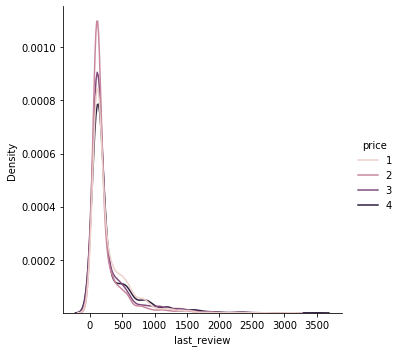

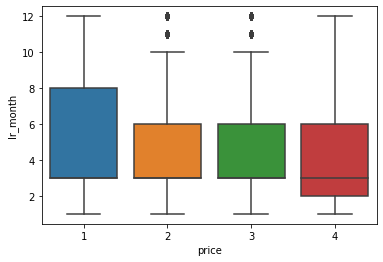

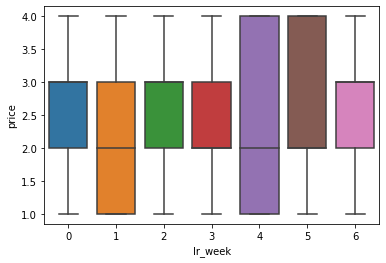

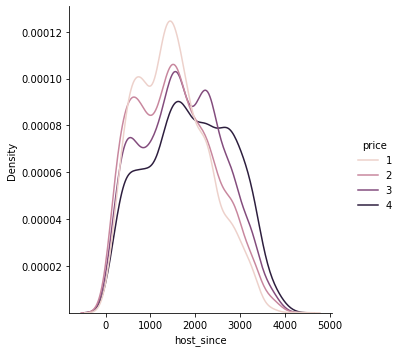

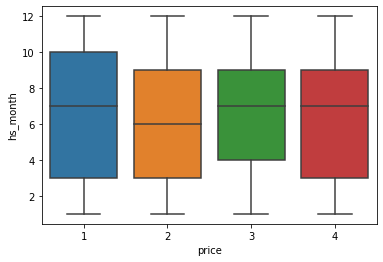

In [8]:
#plots for time features
#last review
sns.displot(dftr, x="last_review", hue="price", kind = 'kde')
plt.show()

sns.boxplot(x="price", y="lr_month", data=dftr)
plt.show()

sns.boxplot(y="price", x="lr_week", data=dftr)
plt.show()

#last review
sns.displot(dftr, x="host_since", hue="price", kind = 'kde')
plt.show()

sns.boxplot(x="price", y="hs_month", data=dftr)
plt.show()

In [9]:
#join data before moving ahead: it is easy to modify both in one go!
y = dftr['price']
Xtrain = dftr.drop(['price'], axis=1)
ntr = Xtrain.shape[0]

data_comp = pd.concat([Xtrain, df],axis=0,ignore_index=True, sort=False)

#make a copy for backtracing mostakes
df1 = data_comp.copy()

## Numerical/continuous features

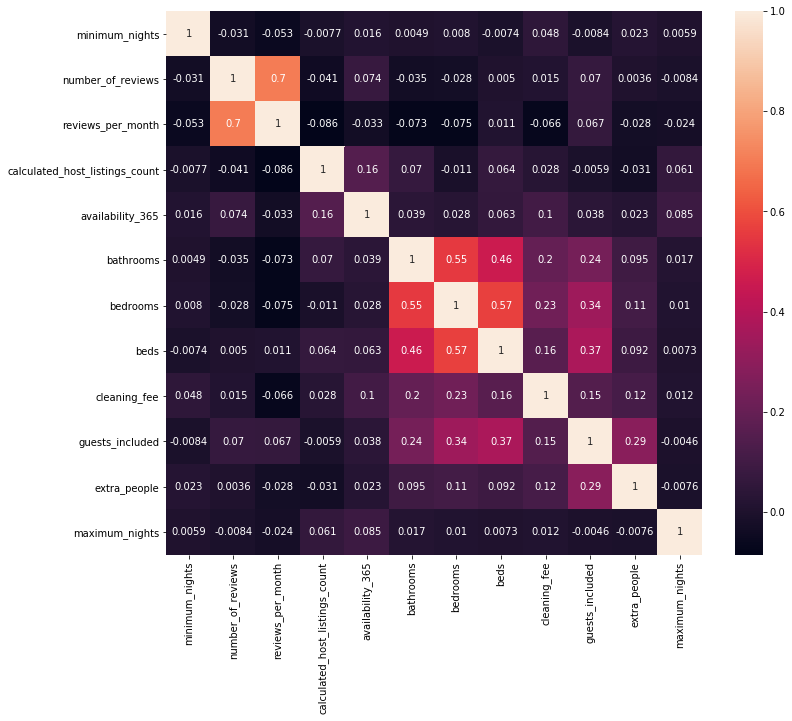

In [10]:
# check some important correlations between numerical features
num_cols = ['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count',
           'availability_365','bathrooms','bedrooms','beds','cleaning_fee', 'guests_included',
           'extra_people','maximum_nights']
sns.heatmap(df1[num_cols].corr(), annot=True)
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.show()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


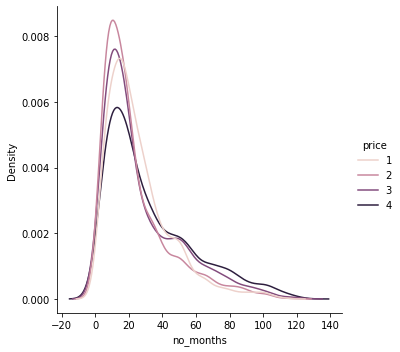

In [11]:
# change number of reviews and reviews per month to a single feature (0.7 corr coeff)
df1['no_months'] = df1['number_of_reviews']/df1['reviews_per_month']

# check distribution of this variable
dftemp = df1.loc[:ntr-1,:]
dftemp['price'] = y
sns.displot(dftemp, x="no_months", hue="price", kind = 'kde')
plt.show()

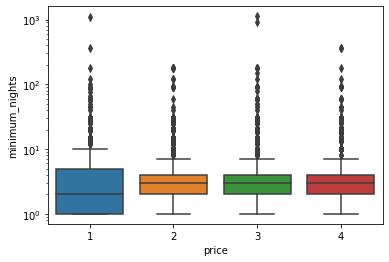

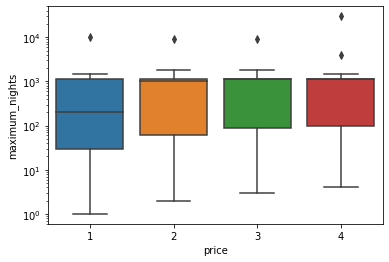

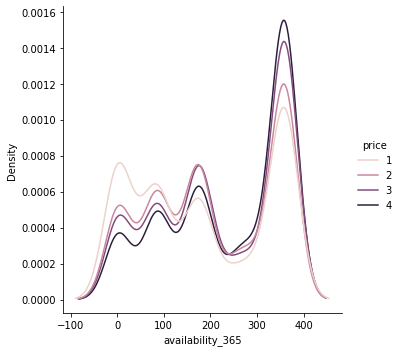

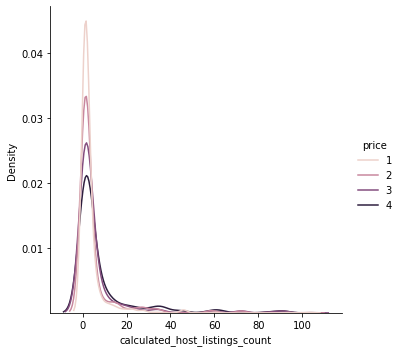

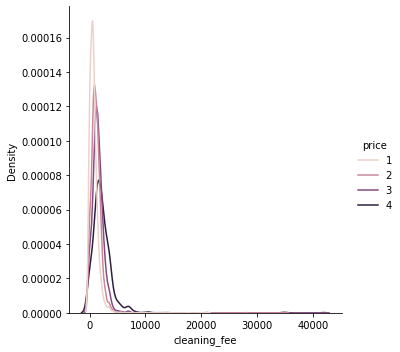

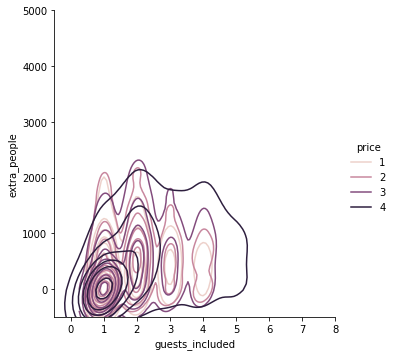

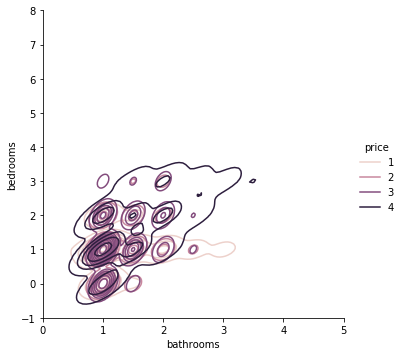

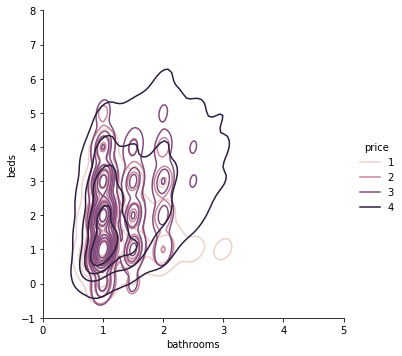

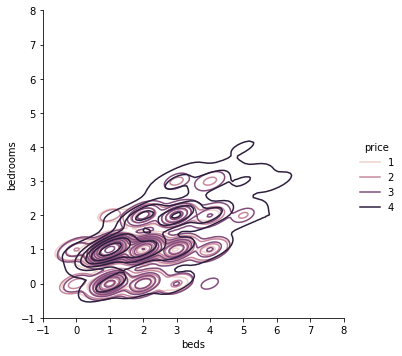

In [12]:
# distribution of other continuous features
ax = sns.boxplot(x="price", y="minimum_nights", data=dftr)
ax.set(yscale = 'log')
plt.show()

ax = sns.boxplot(x="price", y="maximum_nights", data=dftr)
ax.set(yscale = 'log')
plt.show()

sns.displot(dftr, x="availability_365", hue="price", kind = 'kde')
plt.show()

sns.displot(dftr, x="calculated_host_listings_count", hue="price", kind = 'kde')
plt.show()

sns.displot(dftr, x="cleaning_fee", hue="price", kind = 'kde')
plt.show()

# interaction plots for highly correlated features
sns.displot(dftr, x="guests_included", y="extra_people", hue="price", kind = 'kde')
plt.xlim([-0.5,8])
plt.ylim([-500,5000])
plt.show()

sns.displot(dftr, x="bathrooms", y="bedrooms", hue="price", kind = 'kde')
plt.xlim([0,5])
plt.ylim([-1,8])
plt.show()

sns.displot(dftr, x="bathrooms", y="beds", hue="price", kind = 'kde')
plt.xlim([0,5])
plt.ylim([-1,8])
plt.show()

sns.displot(dftr, x="beds", y="bedrooms", hue="price", kind = 'kde')
plt.xlim([-1,8])
plt.ylim([-1,8])
plt.show()


## Nominal features
### Neighbourhood

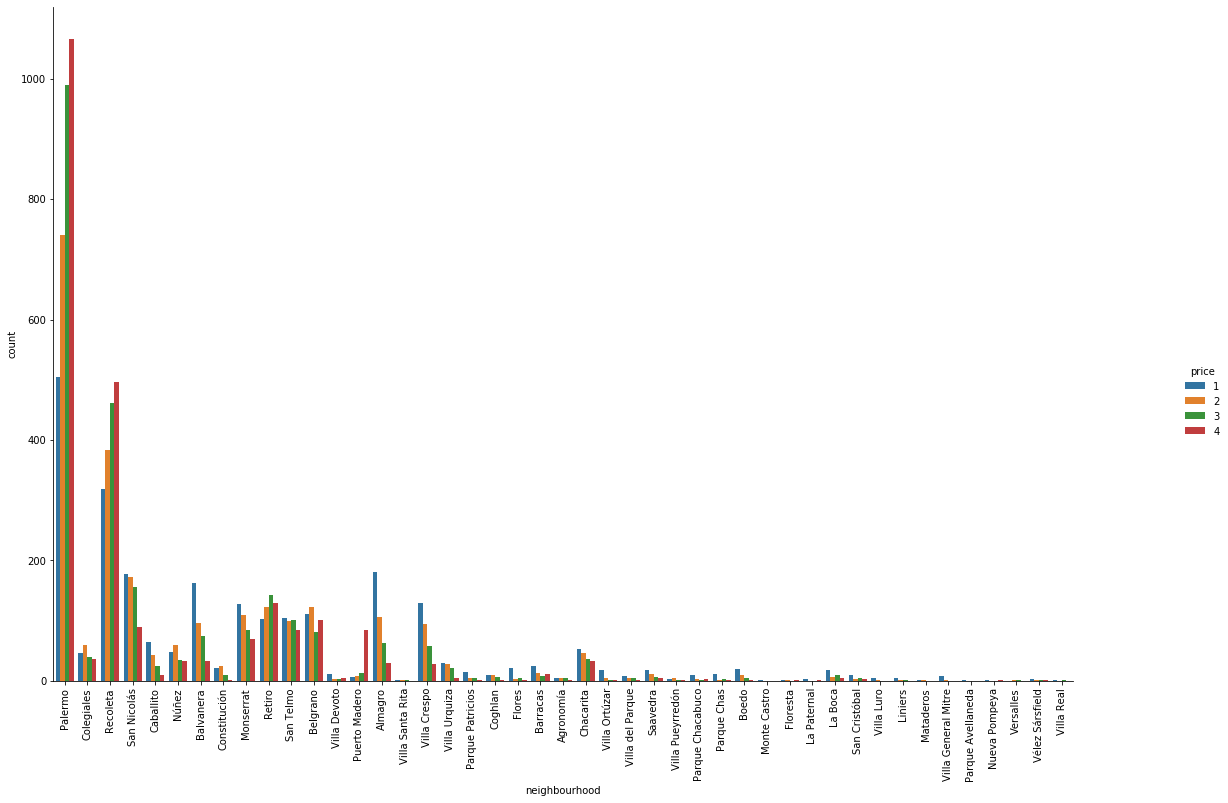

In [13]:
#analyse location data a.k.a neighbourhood
sns.catplot(data=dftr, x="neighbourhood", hue="price", kind="count")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(rotation=90)
plt.show()

#### Airport Distance and City Center Distance

In [14]:
# extracting locational features

## get latitude and longitude data for each neighbourhood
df1['lat'] = 0
df1['long'] = 0
neigh_lats = pd.read_csv('neigh_long_lat.csv')
for index, row in neigh_lats.iterrows():
    for idx, row1 in df1.iterrows():
        if row1['neighbourhood'] == row['neighbourhood']:
            df1.loc[idx,'lat'] = float(row['latlong'].split(',')[0])
            df1.loc[idx,'long'] = float(row['latlong'].split(',')[1])

In [35]:
#latitude and longitude data scraped from google maps
neigh_lats

,neighbourhood,latlong
0,Palermo,"-34.5733577,-58.4560348"
1,Recoleta,"-34.584752,-58.4313622"
2,San Nicolás,"-34.6038852,-58.397801"
3,Retiro,"-34.5893613,-58.3942979"
4,Belgrano,"-34.5553941,-58.4858054"
5,Monserrat,"-34.6125221,-58.3968517"
6,San Telmo,"-34.6225422,-58.3790128"
7,Balvanera,"-34.609286,-58.4206688"
8,Almagro,"-34.6098519,-58.440136"
9,Villa Crespo,"-34.5980347,-58.4586582"


In [15]:
## helper functions to get distance from:
## i. Nearest Airport
def getmingeodist(coord):
    ap1= (-34.5580305,-58.4170088)
    ap2=(-34.8150044,-58.5348284)
    ap3= (-34.6055135,-58.5989835)
    return float(min([geodist.geodesic(coord, ap1).km,geodist.geodesic(coord, ap2).km,geodist.geodesic(coord, ap3).km]))

### get the distance from the nearest airport for each neighbourhood
df1['acdist'] = 0
for i in df1.index:
    df1.loc[i,'acdist'] = getmingeodist((df1.loc[i,'lat'],df1.loc[i,'long']))

## i. City Center
def getmingeodistcc(coord):
    cc= (-34.6052122,-58.4107299)
    return float(geodist.geodesic(coord, cc).km)

### get the distance from the city center
df1['ccdist'] = 0
for i in df1.index:
    df1.loc[i,'ccdist'] = getmingeodistcc((df1.loc[i,'lat'],df1.loc[i,'long']))

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


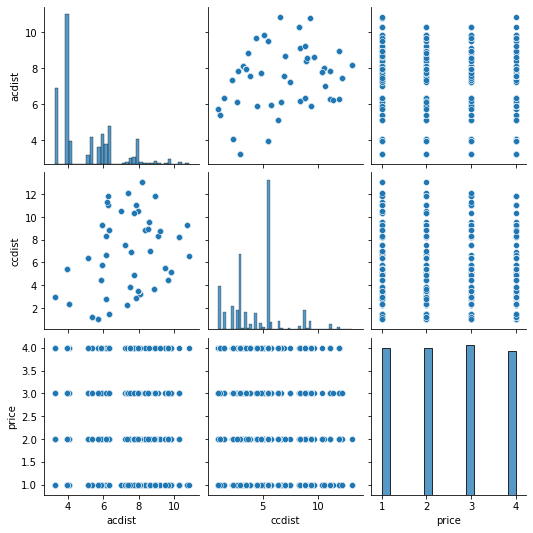

In [16]:
#check pairwise plots for airport distance and city center distance
dftemp = df1.loc[:ntr-1,:]
dftemp['price'] = y
sns.pairplot(dftemp.loc[:ntr-1,['acdist','ccdist','price']])
plt.show()

### Use linear regression to express airport and city center distance as a function of different features

In [17]:
# extract more meaning out of the distance data
# Apply linear regression on numerical data which might affect the distances and get errors

lst = ["minimum_nights","maximum_nights","calculated_host_listings_count","no_months"]
i=len(lst)

## i. Airport distance
reg = LinearRegression().fit(np.array(df1.loc[:ntr-1,lst]).reshape(-1, i), 
                             np.array(df1.loc[:ntr-1,"acdist"]).reshape(-1, 1))

# predict and get error on traindata
nrm = reg.predict(np.array(df1.loc[:ntr-1,lst]).reshape(-1, i))
err1 = np.array(df1.loc[:ntr-1,"acdist"]).reshape(-1, 1) - nrm

#predict and get error on testdata
nrm = reg.predict(np.array(df1.loc[ntr:,lst]).reshape(-1, i))
err2 = np.array(df1.loc[ntr:,"acdist"]).reshape(-1, 1) - nrm

#update acdist with the errors of fitting
df1['acdist'] = pd.DataFrame(np.concatenate((err1,err2)))[0]**2

## ii. City Centre distance
reg = LinearRegression().fit(np.array(df1.loc[:ntr-1,lst]).reshape(-1, i), 
                             np.array(df1.loc[:ntr-1,"ccdist"]).reshape(-1, 1))

# predict and get error on traindata
nrm = reg.predict(np.array(df1.loc[:ntr-1,lst]).reshape(-1, i))
err1 = np.array(df1.loc[:ntr-1,"ccdist"]).reshape(-1, 1) - nrm

# predict and get error on traindata
nrm = reg.predict(np.array(df1.loc[ntr:,lst]).reshape(-1, i))
err2 = np.array(df1.loc[ntr:,"ccdist"]).reshape(-1, 1) - nrm

df1['ccdist'] = pd.DataFrame(np.concatenate((err1,err2)))[0]**2

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


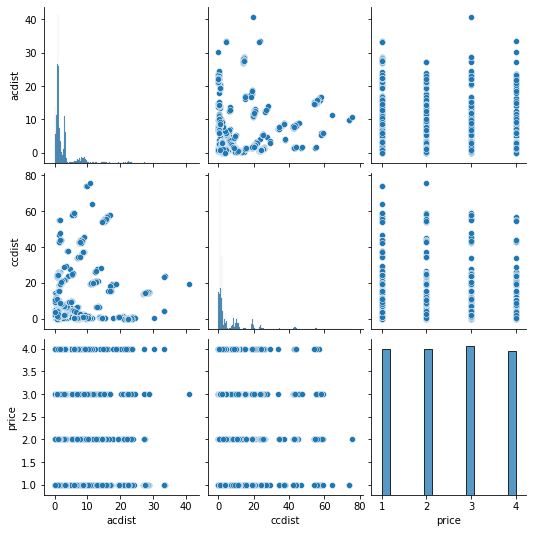

In [18]:
#check pairwise plots for airport distance and city center distance errors after fitting
dftemp = df1.loc[:ntr-1,:]
dftemp['price'] = y
sns.pairplot(dftemp.loc[:ntr-1,['acdist','ccdist','price']])
plt.show()

#### Special encodings

In [19]:
# add special encoding: these are the frequency of different types of place of interests within 500m of the centroid of the neighbourhood
poidf = pd.read_csv('poi_eng.csv')
df1 = pd.merge(df1, poidf, left_on = 'neighbourhood', right_on = 'Neighbourhood', how = 'left').fillna(0)

In [36]:
#neighbourhood vs number of attractions within 500 meters scraped from Foursquare.com
poidf.T

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
Neighbourhood,Agronomía,Almagro,Balvanera,Barracas,Belgrano,Boedo,Caballito,Chacarita,Coghlan,Colegiales,...,Villa Devoto,Villa General Mitre,Villa Luro,Villa Ortúzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Vélez Sársfield
cult,0,0,1,0,1,2,3,0,3,0,...,1,1,0,2,1,2,1,0,0,1
food,13,23,19,1,9,7,10,1,4,15,...,3,5,2,9,0,2,6,2,6,1
sport,0,0,0,0,0,4,0,2,1,0,...,0,0,3,0,1,1,0,0,0,1
ent,0,0,3,1,2,0,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
bank,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bar,2,1,5,1,0,2,0,0,1,1,...,1,0,0,1,0,0,0,0,2,0
utl,0,1,1,0,1,1,0,2,0,0,...,0,0,1,0,1,0,0,0,0,0
center,3,2,1,0,1,1,2,0,0,0,...,1,1,2,3,1,0,0,0,1,1
house,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


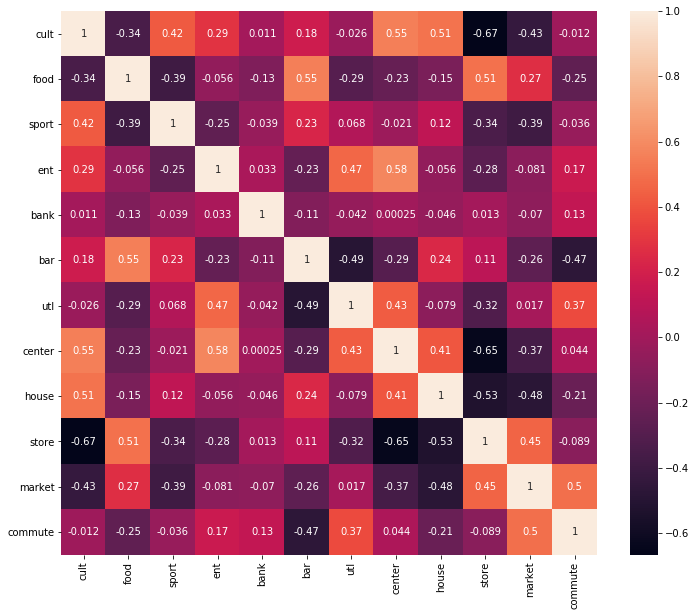

In [20]:
#check if the features are correlated
sns.heatmap(df1.loc[:ntr-1,poidf.columns.to_list()[1:]].corr(), annot=True)
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.show()

### Other nominal features

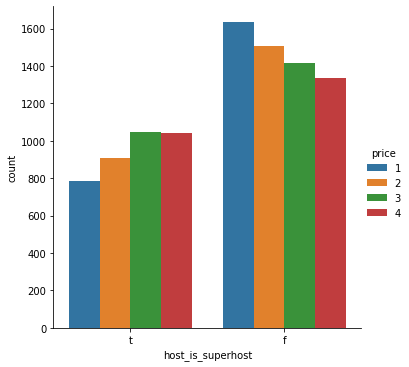

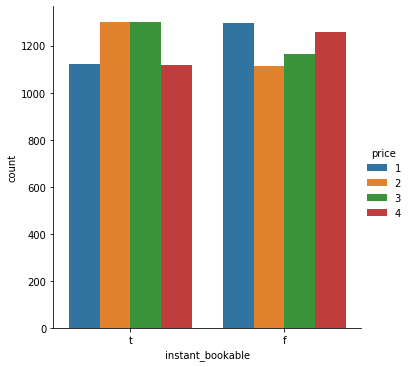

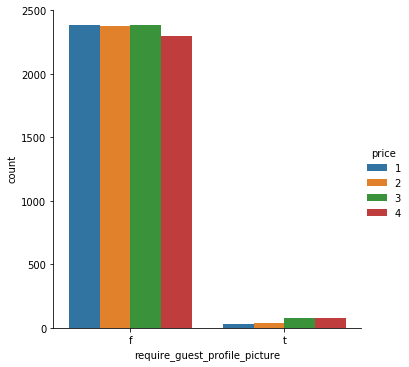

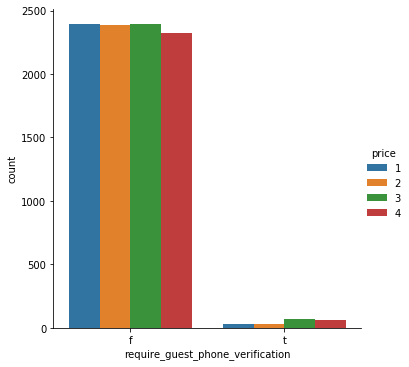

In [21]:
sns.catplot(x="host_is_superhost", hue="price", kind="count", data=dftr)
plt.show()

sns.catplot(x="instant_bookable", hue="price", kind="count", data=dftr)
plt.show()

sns.catplot(x="require_guest_profile_picture", hue="price", kind="count", data=dftr)
plt.show()

sns.catplot(x="require_guest_phone_verification", hue="price", kind="count", data=dftr)
plt.show()

In [22]:
# encode nominal features
nom_cols = ['host_is_superhost','instant_bookable',
            'require_guest_profile_picture','require_guest_phone_verification']


df1 = pd.get_dummies(df1, 
               prefix = nom_cols, 
               columns = nom_cols, 
               drop_first=True, dtype = int) 

## Ordinal features

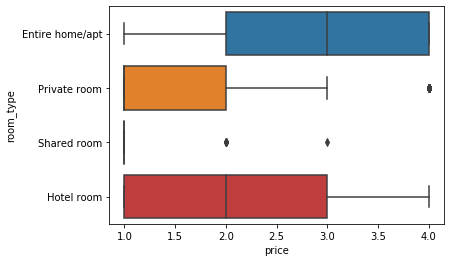

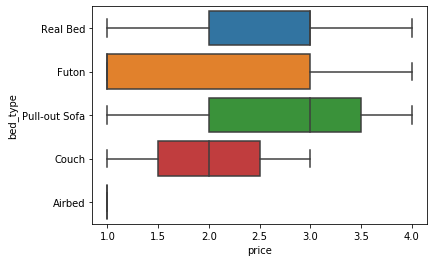

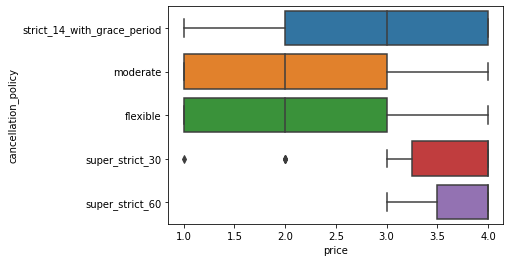

In [23]:
sns.boxplot(x="price", y="room_type", data=dftr)
plt.show()

sns.boxplot(x="price", y="bed_type", data=dftr)
plt.show()

sns.boxplot(x="price", y="cancellation_policy", data=dftr)
plt.show()

In [24]:
# encode the ordinal values based on assumed rank

cats = ['Shared room','Private room', 'Hotel room','Entire home/apt' ]
for i in range(len(cats)):
    df1['room_type'] = df1['room_type'].replace(cats[i], i)
    
cats = ['Airbed', 'Couch','Futon', 'Real Bed', 'Pull-out Sofa']
for i in range(len(cats)):
    df1['bed_type'] = df1['bed_type'].replace(cats[i], i)
    
cats = ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30','super_strict_60']
for i in range(len(cats)):
    df1['cancellation_policy'] = df1['cancellation_policy'].replace(cats[i], i)


### Arbitrary feature

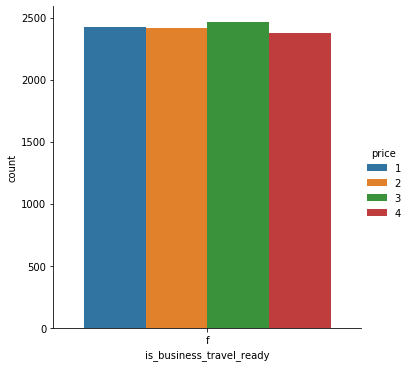

In [25]:
sns.catplot(x="is_business_travel_ready", hue="price", kind="count", data=dftr)
plt.show()

### remove extra features and generate train and test set

In [26]:
# remove
df1.drop(['is_business_travel_ready','lat','long','Neighbourhood','number_of_reviews','reviews_per_month','neighbourhood'],axis=1,inplace= True) #+['lat','long','acdist']

In [27]:
# training and testing data
features_mean = df1.columns[1:]
X = df1.loc[0:ntr-1,features_mean]
X_test = df1.loc[ntr:,features_mean]

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 0 to 9680
Data columns (total 37 columns):
room_type                             9681 non-null int64
minimum_nights                        9681 non-null int64
last_review                           9681 non-null float64
calculated_host_listings_count        9681 non-null int64
availability_365                      9681 non-null int64
host_since                            9681 non-null float64
bathrooms                             9681 non-null float64
bedrooms                              9681 non-null int64
beds                                  9681 non-null int64
bed_type                              9681 non-null int64
cleaning_fee                          9681 non-null int64
guests_included                       9681 non-null int64
extra_people                          9681 non-null int64
maximum_nights                        9681 non-null int64
cancellation_policy                   9681 non-null int64
lr_month         

# Models
## Model 1: Xgboost with gbtree
(all accuracies measured are 5 fold cross validation accuracy)

In [33]:
#use xgboost with default parameters
xgbbasic = xgb.sklearn.XGBClassifier()

start = time.time()
results = cross_val_score(xgbbasic, X, y, cv=5)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for XGboost Classifier: Mean = 55.015%, STD = 1.07%
Execution time: 0.12 min


### Use grid search to tune some of the hyperparameters

In [35]:
xgbtune = xgb.sklearn.XGBClassifier()

# Define initial best params
params = {
    # Tuning parameters
    'n_estimators': [200,500,700], #first check over larger interval
    'max_depth':[6,7,8,9], #limiting depth to 9 (prevent overfitting)
    'min_child_weight': [5,6,7,8], #larger numbers are conservative
    'reg_lambda': [0,.1, .2], #induce penalty
    'reg_alpha': [0,.1, .2], #induce sparsity
    'gamma':[0,.1], #loss reduction during partitioning
    # Fixed parameters
    'learning_rate':[0.1],
    'eta':[0.1],
    'subsample': [1],
    'colsample_bytree': [0.6],
    'booster': ['gbtree'],
    'objective': ['multi:softmax'],
    'nthread': [-1],
    'num_class': [4],
    'eval_metric': ["mae"]
}

#instantiate grid search
gs = GridSearchCV(
    estimator = xgbtune,
    param_grid = params, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 2,
    scoring = 'accuracy'
)

fitted_model = gs.fit(X, y)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed: 84.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 117.9min finished


In [36]:
print('Best accuracy score obtained: ', fitted_model.best_score_)
print('Model parameters generated')
print(fitted_model.best_params_)

Best accuracy score obtained:  0.5636814378679889
Model parameters generated
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'eta': 0.1, 'eval_metric': 'mae', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'nthread': -1, 'num_class': 4, 'objective': 'multi:softmax', 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1}


## finetune model hyperparameters

Execution time: 1.79 min


Text(0.5, 1.0, 'Max depth vs 5 fold CV accuracy')

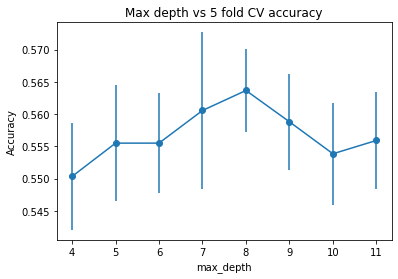

In [30]:
# wrt Max Depth
mdepth = []
scores = []
scstd = []
start = time.time()
for i in range(4,12):
    xgbtemp = xgb.sklearn.XGBClassifier(
                    n_estimators=200,
                    max_depth=i,
                    min_child_weight=5,
                    subsample=1,
                    colsample_bytree=0.6,
                    objective='multi:softmax',
                    nthread=-1,
                    num_class=4,
                    reg_alpha = 0.1,
                    reg_lambda=0,
                    eta=0.1,
                    learning_rate=0.1,
                    eval_metric = 'mae')
    results = cross_val_score(xgbtemp, X, y, cv=5)
    scores += [results.mean()]
    scstd += [results.std()]
    mdepth += [i]
end = time.time()

print("Execution time: %.2f min" % ((end - start)/60))
plt.errorbar(mdepth, scores, yerr=scstd, fmt='-o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Max depth vs 5 fold CV accuracy')

Execution time: 2.60 min


Text(0.5, 1.0, 'l2 regularization vs 5 fold CV accuracy')

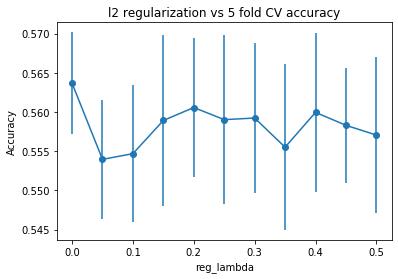

In [31]:
# wrt lambda
lbd = []
scores = []
scstd = []
start = time.time()
for i in np.arange(0,0.55,0.05):
    xgbtemp = xgb.sklearn.XGBClassifier(
                    n_estimators=200,
                    max_depth=8,
                    min_child_weight=5,
                    subsample=1,
                    colsample_bytree=0.6,
                    objective='multi:softmax',
                    nthread=-1,
                    num_class=4,
                    reg_alpha = 0.1,
                    reg_lambda=i,
                    eta=0.1,
                    learning_rate=0.1,
                    eval_metric = 'mae')
    results = cross_val_score(xgbtemp, X, y, cv=5)
    scores += [results.mean()]
    scstd += [results.std()]
    lbd += [i]
end = time.time()

print("Execution time: %.2f min" % ((end - start)/60))
plt.errorbar(lbd, scores, yerr=scstd, fmt='-o')
plt.xlabel('reg_lambda')
plt.ylabel('Accuracy')
plt.title('l2 regularization vs 5 fold CV accuracy')

### Final model

In [56]:
#final model

xgbmodel = xgb.sklearn.XGBClassifier(
                    n_estimators=200,
                    max_depth=8,
                    min_child_weight=5,
                    subsample=1,
                    colsample_bytree=0.6,
                    objective='multi:softmax',
                    nthread=-1,
                    num_class=4,
                    reg_alpha = 0.1,
                    reg_lambda=0,
                    eta=0.1,
                    learning_rate=0.1,
                    eval_metric = 'mae')


start = time.time()
results = cross_val_score(xgbmodel, X, y, cv=5)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for XGboost Classifier: Mean = 56.368%, STD = 0.65%
Execution time: 0.23 min


In [57]:
#generate test prediction for submission
xgbmodel.fit(X,y)
preds = xgbmodel.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

test_preds = xgbmodel.predict(X_test)

dt = {'id': df['id'], 'price': test_preds}
tpdf = pd.DataFrame(dt)
tpdf.to_csv('xgbout.csv', index=False)

Training accuracy: 0.9708707778122094


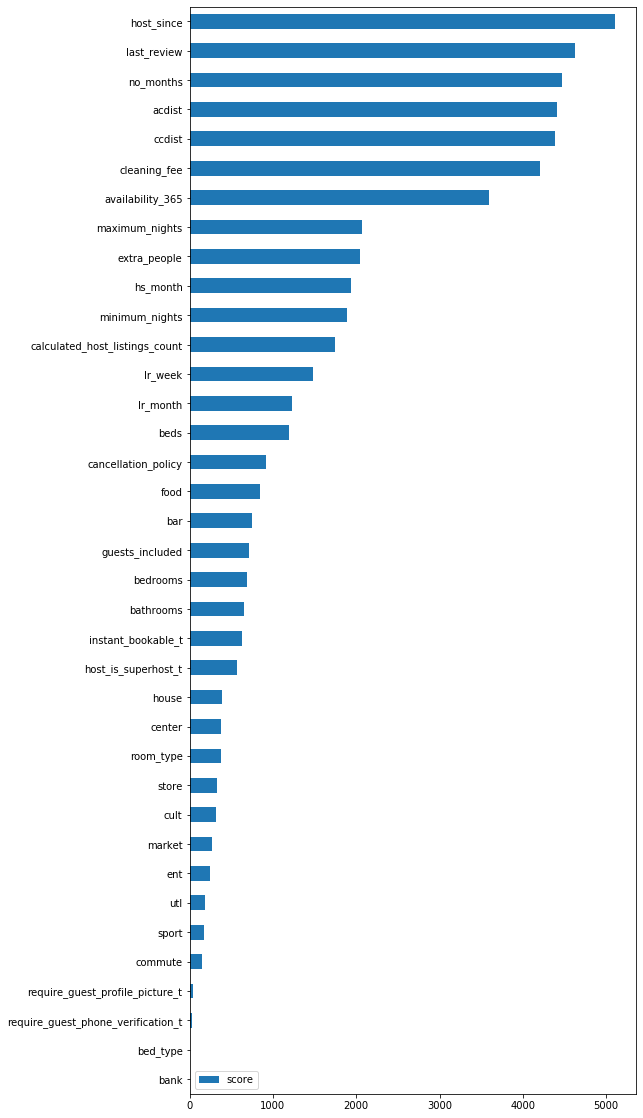

In [58]:
# plot feature importance
feature_important = xgbmodel.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize=(8,20))
plt.show()

## Model 2: Random forest

In [49]:
#use random forest with default parameters
rfbasic = RandomForestClassifier()

start = time.time()
results = cross_val_score(rfbasic, X, y, cv=5)
end = time.time()
print("CV accuracy for Random Forrest Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CV accuracy for Random Forrest Classifier: Mean = 50.904%, STD = 0.98%
Execution time: 0.01 min


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Use grid search to tune some hyperparameters

In [37]:
rftune = RandomForestClassifier()

# Define initial best params
param_grid = {
    'bootstrap': [True],
    'max_depth': [x for x in range(10,30,5)], #similar to xgboost
    'max_features': [4,5,6,8], #features at each split
    'min_samples_leaf': [3, 4, 5,6], #samples required for leaf
    'min_samples_split': [6,8], #samples required for split
    'n_estimators': [x for x in range(200, 800, 100)] #similar to xgboost
}

#perform grid search
gs = GridSearchCV(
    estimator = rftune,
    param_grid = param_grid, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 2,
    scoring = 'accuracy'
)

fitted_model = gs.fit(X, y)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 23.0min finished


In [38]:
print('Best accuracy score obtained: ', fitted_model.best_score_)
print('Model parameters generated')
print(fitted_model.best_params_)

Best accuracy score obtained:  0.5562441896498296
Model parameters generated
{'bootstrap': True, 'max_depth': 25, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 600}


### finetune model hyperparameters

Execution time: 3.37 min


Text(0.5, 1.0, 'Max depth vs 5 fold CV accuracy')

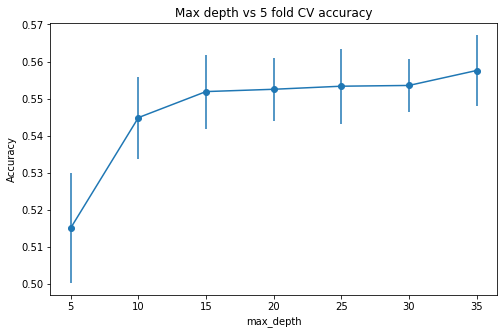

In [43]:
# wrt Max Depth
mdepth = []
scores = []
scstd = []
start = time.time()
for i in range(5,40,5):
    rftemp =  RandomForestClassifier(bootstrap= True,
                                 max_depth= i,
                                 max_features= 8,
                                 min_samples_leaf= 3,
                                 min_samples_split= 6,
                                 n_estimators= 600) 
    results = cross_val_score(rftemp, X, y, cv=5)
    scores += [results.mean()]
    scstd += [results.std()]
    mdepth += [i]
end = time.time()

print("Execution time: %.2f min" % ((end - start)/60))
plt.figure(figsize=(8,5))
plt.errorbar(mdepth, scores, yerr=scstd, fmt='-o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Max depth vs 5 fold CV accuracy')

### Final model

In [46]:
#final model

rfmodel = RandomForestClassifier(bootstrap= True,
                                 max_depth= 25,
                                 max_features= 8,
                                 min_samples_leaf= 3,
                                 min_samples_split= 6,
                                 n_estimators= 600) 

start = time.time()
results = cross_val_score(rfmodel, X, y, cv=5)
end = time.time()
print("CV accuracy for Random Forrest Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for Random Forrest Classifier: Mean = 55.614%, STD = 1.05%
Execution time: 0.56 min


In [47]:
#generate test prediction for submission
rfmodel.fit(X,y)
preds = rfmodel.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

test_preds = rfmodel.predict(X_test)

dt = {'id': df['id'], 'price': test_preds}
tpdf = pd.DataFrame(dt)
tpdf.to_csv('rfout.csv', index=False)

Training accuracy: 0.962193988224357


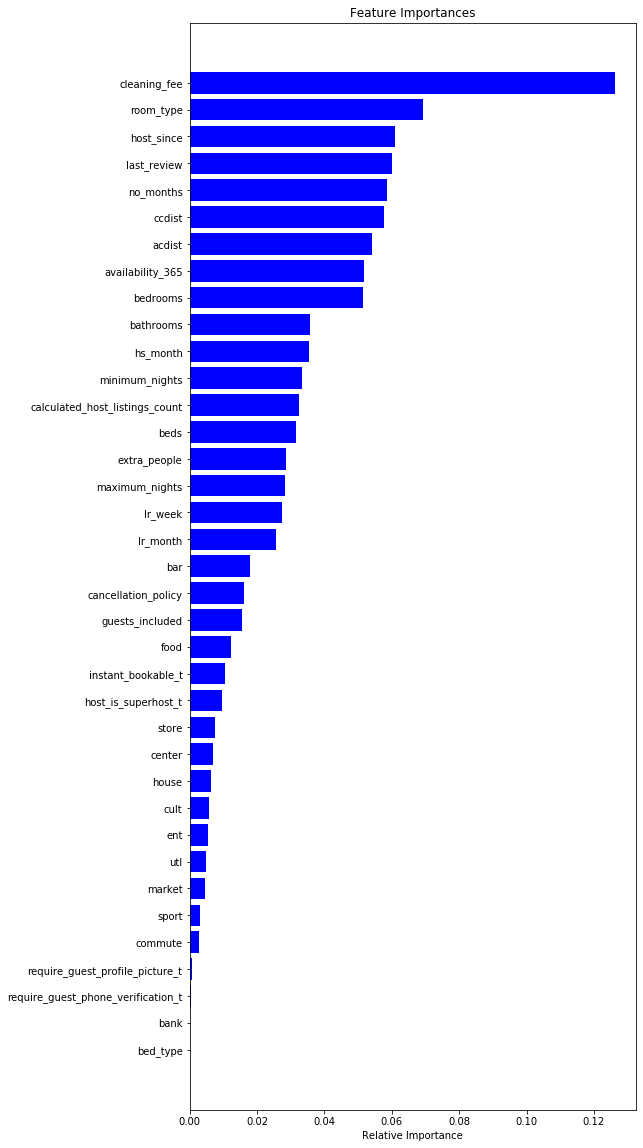

In [48]:
features = features_mean
importances = rfmodel.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()